In [1]:
import sys
sys.path.append('..')

import time
import json
from dataclasses import dataclass
import torch
from PIL import Image, ImageDraw
from transformers import RTDetrImageProcessor
from inference.tensorrt_inference import TensorRTInference

@dataclass
class DetrOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

In [2]:
with open('../../assets/labels.txt', 'r') as f:
    labels = json.loads(f.read())

In [3]:
image_processor = RTDetrImageProcessor.from_pretrained("jadechoghari/RT-DETRv2")
image_processor.size = {'height': 480, 'width': 640}
trt_inference = TensorRTInference("../../model.trt")

In [7]:
start = time.time()
img = Image.open("../../assets/000000039769.jpg")
input_tensor = image_processor(img, return_tensors="pt")
end = time.time()
print(end - start)

start = time.time()
output_data = trt_inference([input_tensor['pixel_values']])
end = time.time()
print(end - start)

start = time.time()
detr_output = DetrOutput(logits = torch.from_numpy(output_data[0].host.reshape((1, -1, 80))),
                         pred_boxes = torch.from_numpy(output_data[1].host.reshape((1, -1, 4))))
results = image_processor.post_process_object_detection(detr_output, target_sizes=torch.tensor([img.size[::-1]]), threshold=0.3)
end = time.time()
print(end - start)

0.011461973190307617
0.0033867359161376953
0.00099945068359375


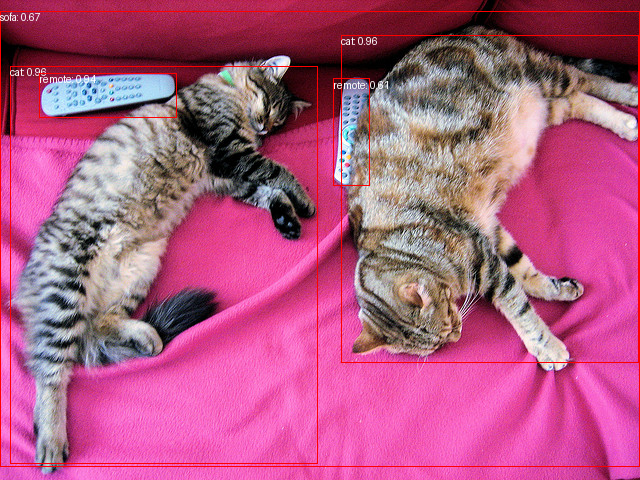

In [9]:
draw_img = img.copy()
draw = ImageDraw.Draw(draw_img)

for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        if score > 0.5:
            draw.rectangle(box, fill=None, outline='red')
            draw.text((box[0], box[1]), f"{labels[str(label)]}: {score:.2f}")

display(draw_img)